# Data Splitting and Image Annotation for Training a Pixel Classifier

This notebook provides a comprehensive guide to split images from different folders into training and validation sets, and to annotate these images for training a pixel classifier. The process involves randomingly copying the original images to new `train` and `validation` folders, plus copying images from a `control` to the `train` folder. Then, it loads the images from the `train` folder into a napari viewer for annotation (the images in `train` folder will be used by the next notebook).

The annotated images are then saved in a folder named `train_annotations`. Finally, each pair of original and annotated images in the `train` and `train_annotations` folders is used to train a temporary pixel classifier and the predictions with post-processing are displayed in the napari viewer for evaluation. If predictions are not satisfactory, the process can be repeated with additional annotations.

The conda environment used for this notebook can be created following the instructions in the [README.md](README.md) file. But in short, we need an environment with the [devbio-napari plugin](https://github.com/haesleinhuepf/devbio-napari).

## Expected folder structure

To run this notebook, you need to place the folders with raw `.tif` images inside a folder named `Spheroids` under a `data` folder in the root of this repository (or adjust the path accordingly). We show an example of the expected folder structure below:

```
Brightfield-3D-models-image-analysis
|
├─ code
|   |
|   ⁞
|   
├─ data
|   |
⁞   ├─ Spheroids
    |    |
    ⁞    ├─ Patient 1
         |    |
         |    ├─ Day 9
         |    |    |
         |    |    ├─ media1.tif
         |    |    ├─ media2.tif
         |    |    ⁞
         |    └─ Day 21
         |         |
         |         ├─ media1.tif
         |         ├─ media2.tif
         |         ⁞
         ├─ Patient 2
         |    |
         |    ├─ Day 9
         |    |    |
         |    |    ├─ media1.tif
         |    |    ├─ media2.tif
         |    |    ⁞
         |    └─ Day 21
         |         |
         |         ├─ media1.tif
         |         ├─ media2.tif
         |         ⁞
         ⁞
         |
         └─ control
              |
              ├─ control_image1.tif
              ⁞
```

## Import libraries

In [ ]:
import napari
from napari.utils import nbscreenshot
from pathlib import Path
from skimage.io import imread, imsave
import random
import numpy as np
import shutil
import apoc
import matplotlib.pyplot as plt
from natsort import natsorted
import json

from utilities import get_layer_position, refine_labels

# Fixed seed for now for reproducibility reasons
seed = 42
random.seed(seed)

## 1. Inputs

- Path to folder with sub-folders containing all images to be analyzed
- Percentage of images to be used for training (default: 60%)
- Percentage of images to be used for validation (default: 20%)
- Minimum area of spheroids to be kept (default: 1000 pixels)

In [2]:
data_path =  Path("../../data/Spheroids/")
training_percentage = 0.6
validation_percentage = 0.2
min_area = 1000

## 2. Create `train` and `validation` folders and copy images

Run the cell below once to create two folders: `train` and `validation`.
Running it a second time raises an error. This is intentional to avoid overwritting the newly created folders.
If you really want to create these folders again, please delete them manually and re-run the cell below.

In [3]:
path_list = [path for path in data_path.rglob("*") if (
    (path.is_file()) 
    and (path.suffix == '.tif')
    and ('train' not in path.parts)
    and ('validation' not in path.parts)
    and ('Outputs' not in path.parts)
    and ('train_annotations' not in path.parts)
    and ('control' not in path.parts))]

# Get paths for images in the 'control' folder
control_path_list = [path for path in data_path.rglob("*") if (
    (path.is_file()) 
    and (path.suffix == '.tif')
    and ('control' in path.parts))]

# Calculate number of images for training and validation sets
n_images = len(path_list) + len(control_path_list)
n_train = int(n_images * training_percentage) - len(control_path_list)
n_validation = n_images - n_train - len(control_path_list)

# Get some paths for training
train_paths = random.choices(path_list, k=n_train)
# Create a train folder (raises error if folder already exist to avoid overwriting files)
training_set_folder_path = data_path / 'train'
try:
    training_set_folder_path.mkdir(exist_ok = False)
except FileExistsError:
    print('Warning! Folder ', training_set_folder_path, ' already exists. To create a new training set, manually delete the folder and run this cell again.')
    raise
# Copy files to train folder
_ = [shutil.copy(path, training_set_folder_path / (path.stem + '.tif')) for path in train_paths]
# Copy files from control folder to train folder
_ = [shutil.copy(path, training_set_folder_path / (path.stem + '.tif')) for path in control_path_list]

# update path list with just remaining paths
path_list = [path for path in path_list if path not in train_paths]
# Get paths for validation
validation_paths = random.choices(path_list, k=n_validation)
# Create a validation folder (raises error if folder already exist to avoid overwriting files)
validation_set_folder_path = data_path / 'validation'
try:
    validation_set_folder_path.mkdir(exist_ok = False)
except FileExistsError:
    print('Warning! Folder ', validation_set_folder_path, ' already exists. To create a new validation set, manually delete the folder and run this cell again.')
    raise
# Copy files to validation folder
_ = [shutil.copy(path, validation_set_folder_path / (path.stem + '.tif')) for path in validation_paths]

## 3. Open images for training in napari and annotate them

Load train images paths and, if existing, annotation images as napari layers. Manual annotations will only be loaded if the `train_annotations` folder is populated with the same number of images as the `train` folder with the same file names. Otherwise, empty annotation layers will be created.

In [4]:
training_set_folder_path = data_path / 'train'
training_annotations_folder_path = data_path / 'train_annotations'
# Create training annotations folder if it does not exist yet
if training_annotations_folder_path.exists() ==  False:
    training_annotations_folder_path.mkdir(exist_ok = True)

train_images_paths = [path for path in training_set_folder_path.iterdir()]
annotation_images_paths = [path for path in training_annotations_folder_path.iterdir()]

viewer = napari.Viewer()

# If folder has previous annotations, open them
if len(annotation_images_paths) > 0 and (len(annotation_images_paths) == len(train_images_paths)):
    for train_path, annotation_path in zip(train_images_paths, annotation_images_paths):
        image = imread(train_path)
        annotation = imread(annotation_path)
        viewer.add_image(image, name = train_path.stem)
        viewer.add_labels(annotation, name = annotation_path.stem)

# otherwise create empty labels layers for annotations
else:
    for train_path in train_images_paths:
        image = imread(train_path)
        viewer.add_image(image, name = train_path.stem)
        viewer.add_labels(np.zeros_like(image), name = 'Annotation of ' + train_path.stem)

Assistant skips harvesting pyclesperanto as it's not installed.


## 4. Save annotated images to disk

Running the cell below will overwrite previous annotations by the currently displayed annotations in napari.

In [7]:
for layer in viewer.layers:
    if layer.name.startswith('Annotation'):
        if not layer.data.any():
            print('Warning! Layer ', layer.name, ' has no annotations!')
        file_name = layer.name + '.tif'
        imsave(training_annotations_folder_path / file_name, layer.data)
annotation_images_paths = [path for path in training_annotations_folder_path.iterdir() if path.stem.startswith('Annotation')]

C:\Users\mazo260d\AppData\Local\Temp\ipykernel_18380\4031384476.py:6: UserWarning: C:\Users\mazo260d\Documents\GitHub\Brightfield-3D-models-image-analysis\data\Spheroids\train_annotations\Annotation of organoids_B070799EFE6-C990-4640-8A06-7F871FDA031F.tif is a low contrast image
  imsave(training_annotations_folder_path / file_name, layer.data)
C:\Users\mazo260d\AppData\Local\Temp\ipykernel_18380\4031384476.py:6: UserWarning: C:\Users\mazo260d\Documents\GitHub\Brightfield-3D-models-image-analysis\data\Spheroids\train_annotations\Annotation of organoids_B08D1CF1EC4-FE5B-43FE-9067-B4964B21ED4D.tif is a low contrast image
  imsave(training_annotations_folder_path / file_name, layer.data)
C:\Users\mazo260d\AppData\Local\Temp\ipykernel_18380\4031384476.py:6: UserWarning: C:\Users\mazo260d\Documents\GitHub\Brightfield-3D-models-image-analysis\data\Spheroids\train_annotations\Annotation of organoids_C08AA9B4BFC-19BB-4946-82FB-123A357B5E47.tif is a low contrast image
  imsave(training_annotati

## 5. Check Individual Predictions for Training Set

This gives prediction for individual models for each image as an initial feedback.

In [8]:
plot_inline = False # Set this to True if you want to plot the images inline in the notebook

# Define features: original image, a blurred version and an edge image
features = ("original gaussian_blur=0.5 difference_of_gaussian=0.5 laplace_diamond_of_gaussian_blur=0.5 difference_of_gaussian=0.5 " +\
            "gaussian_blur=1 difference_of_gaussian=1 laplace_diamond_of_gaussian_blur=1 difference_of_gaussian=1 " +\
            "gaussian_blur=2 difference_of_gaussian=2 laplace_diamond_of_gaussian_blur=2 difference_of_gaussian=2 " +\
            "gaussian_blur=5 difference_of_gaussian=5 laplace_diamond_of_gaussian_blur=5 difference_of_gaussian=5 " +\
            "gaussian_blur=10 difference_of_gaussian=10 laplace_diamond_of_gaussian_blur=10 difference_of_gaussian=10")

# this is where the temporary model will be saved
cl_filename = data_path / 'temp_model.cl'

# Remove previous predictions from viewer, if present
prediction_layers_positions = [get_layer_position(viewer, layer.name) for layer in viewer.layers if layer.name.startswith('Prediction')]
if len(prediction_layers_positions) > 0:
    for pos in reversed(prediction_layers_positions):
        viewer.layers.pop(pos)
        
if plot_inline:
    fig, ax = plt.subplots(len(train_images_paths), 2, figsize=(10,15))
    
for image_path, annotations_path, i in zip(natsorted(train_images_paths), natsorted(annotation_images_paths), range(len(train_images_paths))):
    image = imread(image_path)
    annotations = imread(annotations_path)

    apoc.erase_classifier(cl_filename)
    clf = apoc.PixelClassifier(opencl_filename=cl_filename)
    clf.train(features, annotations, image)
    result = clf.predict(image=image)
    result_refined = refine_labels(result, min_area = min_area)

    viewer.add_labels(result_refined, name = 'Prediction of ' + image_path.stem)
    name = image_path.stem
    pos = get_layer_position(viewer, name)
    viewer.layers.insert(pos+2, viewer.layers.pop(-1)) # puts points layer 2 positions above image layer (just above corresponding labels layer)
    if plot_inline:
        ax[i,0].imshow(image, cmap='gray')
        ax[i,0].axis('off')
        ax[i,1].imshow(result, interpolation='nearest')
        ax[i,1].axis('off')
if plot_inline:     
    plt.tight_layout()

viewer.grid.enabled = True

# Save min_area in json file
min_area_dict = {'min_area': min_area}
with open(data_path / 'min_area.json', 'w') as f:
    json.dump(min_area_dict, f)


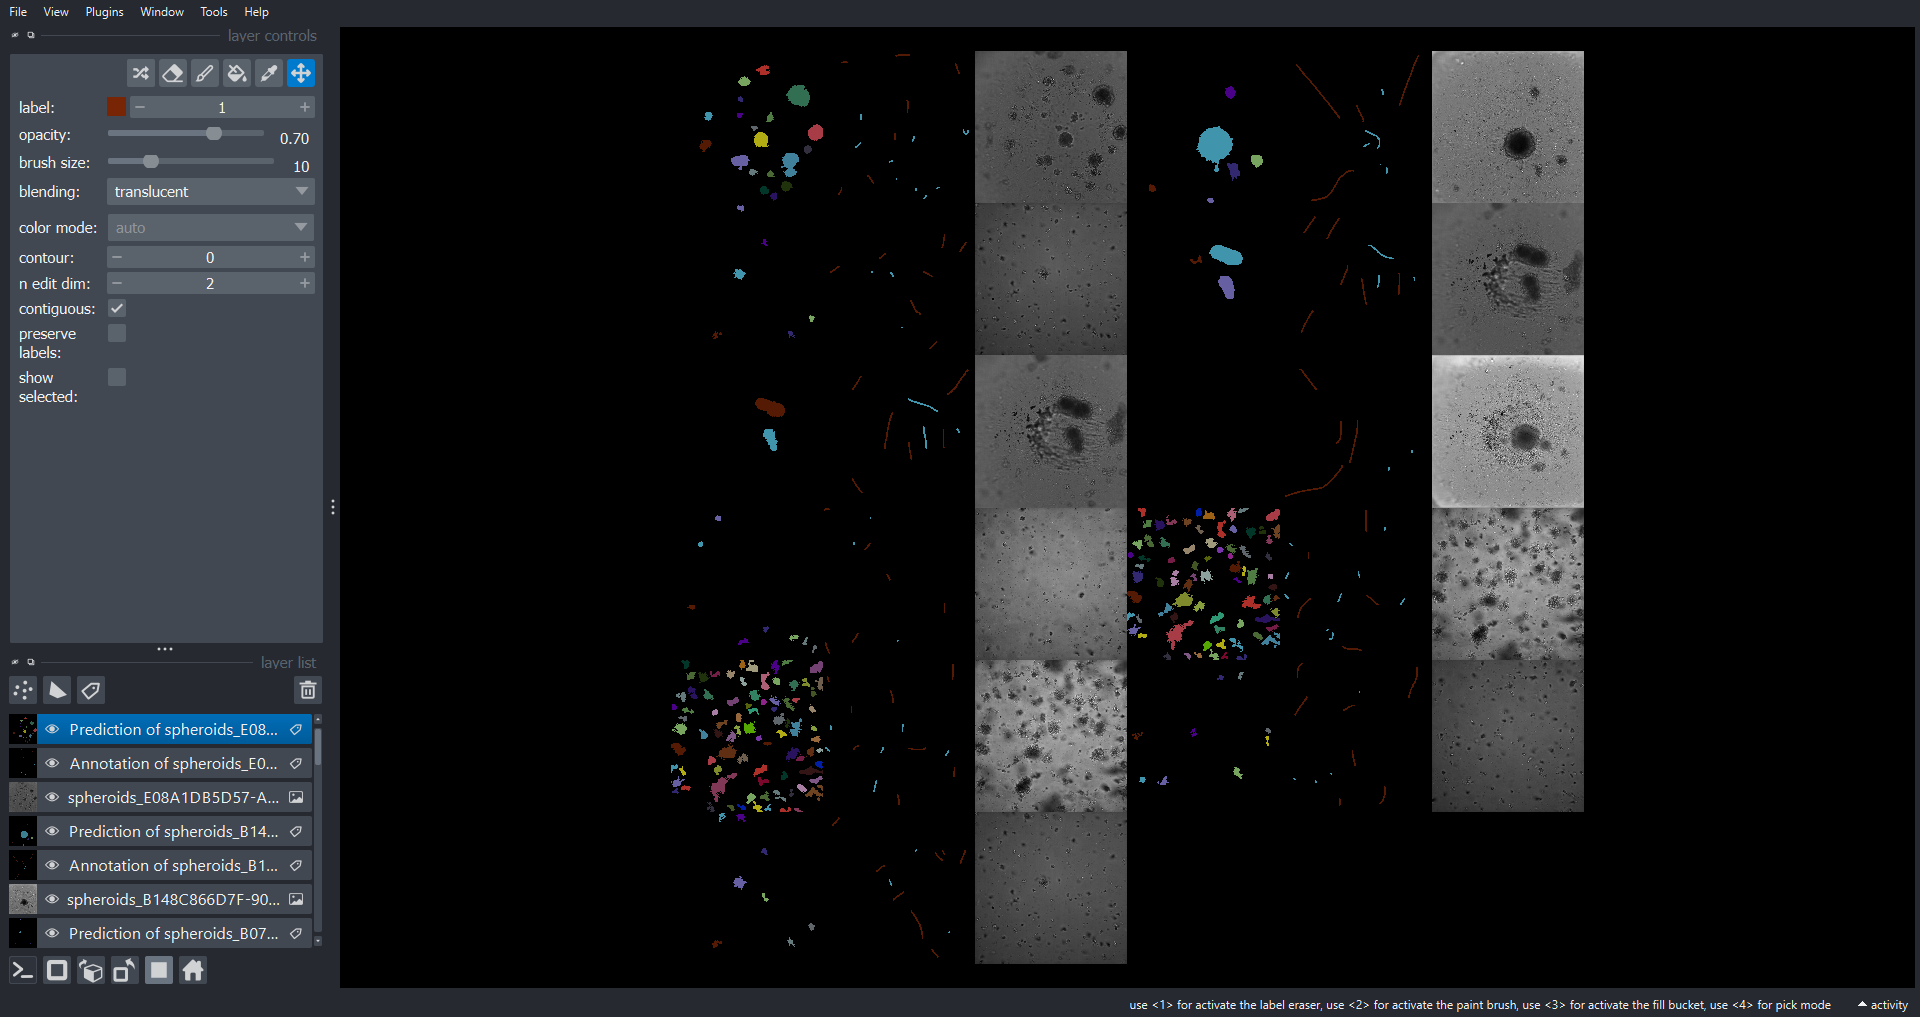

In [9]:
nbscreenshot(viewer)

### Improve annotations (optional)

Provide some extra annotations to the **Annotation layers** (annotating on Prediction layers will have no effect) and re-run cells starting from **[4. Save annotated images to disk](#4_save_annotated_images_to_disk)**.
